In [98]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

seed = 42
random.seed(seed)
torch.cuda.manual_seed_all(seed)

N = 10000
M = 100
c = 0.5
p = 0.9
k = np.random.randn(M)
u1 = np.random.randn(M)
u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
u1 /= np.linalg.norm(u1) 
k /= np.linalg.norm(k) 
u2 = k
w1 = c*u1
w2 = c*(p*u1+np.sqrt((1-p**2))*u2)
X = np.random.normal(0, 1, (N, M))
eps1 = np.random.normal(0, 0.01)
eps2 = np.random.normal(0, 0.01)
Y1 = np.matmul(X, w1) + np.sin(np.matmul(X, w1))+eps1
Y2 = np.matmul(X, w2) + np.sin(np.matmul(X, w2))+eps2
split = list(np.random.permutation(N))

X_train = X[split[0:8000],:]
Y1_train = Y1[split[0:8000]]
Y2_train = Y2[split[0:8000]]
X_valid = X[8000:9000,:]
Y1_valid = Y1[8000:9000]
Y2_valid = Y2[8000:9000]
X_test = X[9000:10000,:]
Y1_test = Y1[9000:10000]
Y2_test = Y2[9000:10000]
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

X_train = torch.from_numpy(X_train)
X_train = X_train.float()
Y1_train = torch.tensor(Y1_train)
Y1_train = Y1_train.float()
Y2_train = torch.tensor(Y2_train)
Y2_train = Y2_train.float()

X_valid = torch.from_numpy(X_valid)
X_valid = X_valid.float()
Y1_valid = torch.tensor(Y1_valid)
Y1_valid = Y1_valid.float()
Y2_valid = torch.tensor(Y2_valid)
Y2_valid = Y2_valid.float()

X_test = torch.from_numpy(X_test)
X_test = X_test.float()
Y1_test = torch.tensor(Y1_test)
Y1_test = Y1_test.float()
Y2_test = torch.tensor(Y2_test)
Y2_test = Y2_test.float()

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

(8000, 100)
(1000, 100)
(1000, 100)
(8000,)
(8000,)
(1000,)
(1000,)
(1000,)
(1000,)
torch.Size([8000, 100])
torch.Size([1000, 100])
torch.Size([1000, 100])
torch.Size([8000])
torch.Size([8000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


In [99]:
input_size, feature_size = X.shape
shared_layer_size = 64
tower_h1 = 32
tower_h2 = 16
output_size = 1
LR = 0.001
epoch = 50
mb_size = 100
cost1tr = []
cost2tr = []
cost1D = []
cost2D = []
cost1ts = []
cost2ts = []
costtr = []
costD = []
costts = []

class MTLnet(nn.Module):
    def __init__(self):
        super(MTLnet, self).__init__()
        self.sharedlayer = nn.Sequential(
            nn.Linear(feature_size, shared_layer_size),
            nn.ReLU(),
            nn.Dropout()
        )
        self.tower1 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )
        self.tower2 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )        

    def forward(self, x):
        h_shared = self.sharedlayer(x)
        out1 = self.tower1(h_shared)
        out2 = self.tower2(h_shared)
        return out1, out2

def random_mini_batches(XE, R1E, R2E, mini_batch_size = 10, seed = 42): 
    # Creating the mini-batches
    np.random.seed(seed)            
    m = XE.shape[0]                  
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_XE = XE[permutation,:]
    shuffled_X1R = R1E[permutation]
    shuffled_X2R = R2E[permutation]
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_XE = shuffled_XE[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_X1R = shuffled_X1R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_X2R = shuffled_X2R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    Lower = int(num_complete_minibatches * mini_batch_size)
    Upper = int(m - (mini_batch_size * math.floor(m/mini_batch_size)))
    if m % mini_batch_size != 0:
        mini_batch_XE = shuffled_XE[Lower : Lower + Upper, :]
        mini_batch_X1R = shuffled_X1R[Lower : Lower + Upper]
        mini_batch_X2R = shuffled_X2R[Lower : Lower + Upper]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    
    return mini_batches

Weightloss1 = torch.FloatTensor([1]).clone().detach().requires_grad_(True)
Weightloss2 = torch.FloatTensor([1]).clone().detach().requires_grad_(True)

params = [Weightloss1, Weightloss2]
MTL = MTLnet()
opt1 = torch.optim.Adam(MTL.parameters(), lr=LR)
opt2 = torch.optim.Adam(params, lr=LR)
loss_func = nn.MSELoss()
Gradloss = nn.L1Loss()

Iter-0; MTL loss: 0.7471
Iter-0; Grad loss: 0.09167
Iter-1; MTL loss: 0.5504
Iter-1; Grad loss: 0.07605
Iter-2; MTL loss: 0.3676
Iter-2; Grad loss: 0.06084
Iter-3; MTL loss: 0.3492
Iter-3; Grad loss: 0.02566
Iter-4; MTL loss: 0.3463
Iter-4; Grad loss: 0.05505
Iter-5; MTL loss: 0.2853
Iter-5; Grad loss: 0.1282
Iter-6; MTL loss: 0.2592
Iter-6; Grad loss: 0.09379
Iter-7; MTL loss: 0.2881
Iter-7; Grad loss: 0.003328
Iter-8; MTL loss: 0.2563
Iter-8; Grad loss: 0.05724
Iter-9; MTL loss: 0.2344
Iter-9; Grad loss: 0.03611
Iter-10; MTL loss: 0.2138
Iter-10; Grad loss: 0.1331
Iter-11; MTL loss: 0.2341
Iter-11; Grad loss: 0.09336
Iter-12; MTL loss: 0.1812
Iter-12; Grad loss: 0.06965
Iter-13; MTL loss: 0.2046
Iter-13; Grad loss: 0.01272
Iter-14; MTL loss: 0.2242
Iter-14; Grad loss: 0.04169
Iter-15; MTL loss: 0.1974
Iter-15; Grad loss: 0.06342
Iter-16; MTL loss: 0.1709
Iter-16; Grad loss: 0.0218
Iter-17; MTL loss: 0.2159
Iter-17; Grad loss: 0.02622
Iter-18; MTL loss: 0.1814
Iter-18; Grad loss: 0.00

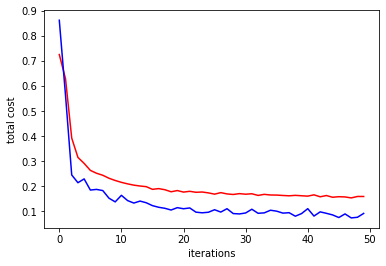

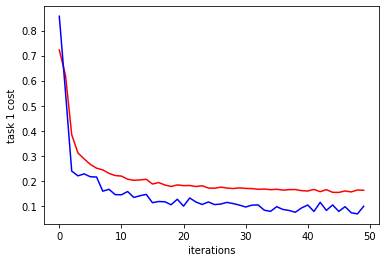

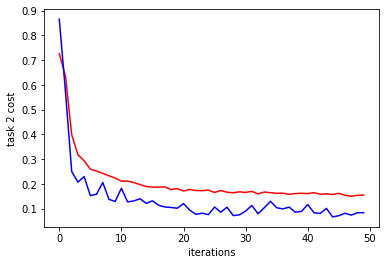

In [100]:
alph = 0.16
for it in range(epoch):
    epoch_cost = 0
    epoch_cost1 = 0
    epoch_cost2 = 0
    coef = 0
    num_minibatches = int(input_size / mb_size) 
    minibatches = random_mini_batches(X_train, Y1_train, Y2_train, mb_size)
    for minibatch in minibatches:
        MTL.train()
        XE, YE1, YE2  = minibatch 
        
        Yhat1, Yhat2 = MTL(XE)
        l1 = params[0]*loss_func(Yhat1, YE1.view(-1,1))    
        l2 = params[1]*loss_func(Yhat2, YE2.view(-1,1))
        loss = torch.div(torch.add(l1,l2), 2)

        # for the first epoch with no l0
        if it == 0:
            l01 = l1.data  
            l02 = l2.data
        
        opt1.zero_grad()
        
        loss.backward(retain_graph=True)   
        
        # Getting gradients of the first layers of each tower and calculate their l2-norm 
        param = list(MTL.parameters())
        G1R = torch.autograd.grad(l1, param[0], retain_graph=True, create_graph=True)
        G1 = torch.norm(G1R[0], 2)
        G2R = torch.autograd.grad(l2, param[0], retain_graph=True, create_graph=True)
        G2 = torch.norm(G2R[0], 2)
        G_avg = torch.div(torch.add(G1, G2), 2)
        
        # Calculating relative losses 
        lhat1 = torch.div(l1,l01)
        lhat2 = torch.div(l2,l02)
        lhat_avg = torch.div(torch.add(lhat1, lhat2), 2)
        
        # Calculating relative inverse training rates for tasks 
        inv_rate1 = torch.div(lhat1,lhat_avg)
        inv_rate2 = torch.div(lhat2,lhat_avg)
        
        # Calculating the constant target for Eq. 2 in the GradNorm paper
        C1 = G_avg*(inv_rate1)**alph
        C2 = G_avg*(inv_rate2)**alph
        C1 = C1.detach()
        C2 = C2.detach()
        
        opt2.zero_grad()
        # Calculating the gradient loss according to Eq. 2 in the GradNorm paper
        Lgrad = torch.add(Gradloss(G1, C1),Gradloss(G2, C2))
        Lgrad.backward()
        
        # Updating loss weights 
        opt2.step()

        # Updating the model weights
        opt1.step()

        # Renormalizing the losses weights
        coef = 2/torch.add(Weightloss1, Weightloss2)
        params = [coef*Weightloss1, coef*Weightloss2]
        # print("Weights are:",Weightloss1, Weightloss2)
        # print("params are:", params)
        epoch_cost = epoch_cost + (loss / num_minibatches)
        epoch_cost1 = epoch_cost1 + (l1 / num_minibatches)
        epoch_cost2 = epoch_cost2 + (l2 / num_minibatches)
        
    costtr.append(torch.mean(epoch_cost).detach().numpy())
    cost1tr.append(torch.mean(epoch_cost1).detach().numpy())
    cost2tr.append(torch.mean(epoch_cost2).detach().numpy())
    
    with torch.no_grad():
        MTL.eval()
        Yhat1D, Yhat2D = MTL(X_valid)
        l1D = params[0]*loss_func(Yhat1D, Y1_valid.view(-1,1))
        l2D = params[1]*loss_func(Yhat2D, Y2_valid.view(-1,1))
        cost1D.append(l1D)
        cost2D.append(l2D)
        costD.append(torch.div(torch.add(l1D,l2D),2))
        print('Iter-{}; MTL loss: {:.4}'.format(it, loss.item()))
        print('Iter-{}; Grad loss: {:.4}'.format(it, Lgrad.item()))

plt.plot(np.squeeze(costtr),'-r',np.squeeze(costD),'-b')
plt.ylabel('total cost')
plt.xlabel('iterations')
plt.savefig('./img/costtr-costD.png', facecolor='white', transparent=False) 
plt.show()

plt.plot(np.squeeze(cost1tr),'-r', np.squeeze(cost1D), '-b')
plt.ylabel('task 1 cost')
plt.xlabel('iterations')
plt.savefig('./img/cost1tr-cost1D.png', facecolor='white', transparent=False)  
plt.show()

plt.plot(np.squeeze(cost2tr),'-r', np.squeeze(cost2D),'-b')
plt.ylabel('task 2 cost')
plt.xlabel('iterations')
plt.savefig('./img/cost2tr-cost2D.png', facecolor='white', transparent=False) 
plt.show()